# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.25,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b512_custom/lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.25
lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_5_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  7.8min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,0.000,-0.402,-0.741,0.255,0.960,-0.220,4.147,-9.243,5.845,-0.821,0.960,-0.220,4.147,-9.243,5.845,-0.821,-0.009,-0.227,0.364,0.298,0.191,0.126,0.367,-0.297,0.287,0.088,0.478,-0.088,-0.019,0.389,0.114,0.453,-0.019,0.226,0.285,0.251,-0.026,0.042,0.008,-0.042,-0.404,-0.090,0.276,-0.291,-0.209,-0.233,0.000,0.000,-0.163,-0.153,0.232,0.232,-0.189,0.000,-0.152,0.302,-0.198,0.000,0.000,-0.188,0.241,-0.188,0.229,0.253,0.224,0.241,0.287,-0.046,-0.023,0.000,0.000,0.000,-0.154,0.000,0.000,0.000,-0.254,-0.359,-0.466,-0.542,0.347,0.404,-0.340,-0.408,-0.618,0.126,-0.290,-0.352,-0.364,-0.328,0.344,-0.371,0.683,0.222,0.357,0.252,0.334,-0.310,-0.044,-0.261,-0.383,-0.059,-0.772,0.144,-0.258,-0.315,0.199
4684,1373158606,-0.794,0.241,0.000,-0.188,-0.535,-0.939,-0.406,-1.044,-0.192,0.865,-0.997,0.386,-0.406,-1.044,-0.192,0.865,-0.997,0.386,-0.009,-0.227,0.374,0.268,0.159,0.097,0.334,-0.297,0.235,0.410,0.500,-0.088,-0.019,0.379,0.095,0.483,0.008,0.216,0.244,0.227,0.033,0.183,0.133,-0.042,-0.404,-0.090,0.194,-0.291,-0.209,-0.233,0.000,0.000,0.090,0.090,-0.070,-0.069,0.094,0.000,0.090,0.109,0.093,0.000,0.000,0.093,-0.067,0.091,-0.023,-0.064,-0.074,-0.069,-0.040,0.090,0.102,0.000,0.000,0.000,0.090,0.000,0.000,0.000,-0.254,-0.359,-0.390,-0.386,0.152,0.189,-0.230,-0.408,-0.410,-0.119,-0.255,-0.352,-0.364,-0.248,0.123,-0.332,0.394,0.030,0.187,0.070,0.049,-0.451,-0.178,-0.261,-0.383,-0.059,-0.478,0.144,-0.258,-0.315,-0.086
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.000,-0.557,-1.705,11.649,-20.051,22.050,-9.235,-0.557,-1.705,11.649,-20.051,22.050,-9.235,-0.009,-0.227,0.096,0.084,0.705,0.588,0.205,-0.297,0.066,0.916,0.314,-0.088,-0.019,0.350,0.604,0.091,0.461,0.809,0.780,0.803,0.586,0.038,0.005,-0.042,-0.404,-0.090,0.045,-0.291,-0.209,-0.233,0.000,0.000,-0.103,-0.093,-0.169,-0.333,-0.123,0.000,-0.079,-0.193,0.012,0.000,0.000,-0.208,-0.341,0.465,-0.271,-0.178,-0.164,-0.170,-0.341,-0.053,-0.024,0.000,0.000,0.000,-0.059,0.000,0.000,0.000,-0.254,-0.359,-0.129,-0.216,0.713,0.804,0.124,-0.408,-0.251,0.496,0.049,-0.352,-0.364,0.246,0.744,-0.300,1.120,0.590,0.727,0.622,0.741,-0.305,-0.041,-0.261,-0.383,-0.059,-0.330,0.144,-0.258,-0.315,-0.464
4742,1373158606,0.173,-0.607,-0.085,0.000,-0.828,-0.939,0.108,1.340,-15.709,48.179,-62.378,26.516,0.108,1.340,-15.709,48.179,-62.378,26.516,-0.009,-0.227,0.557,0.481,0.080,0.078,0.572,-0.297,0.458,0.697,0.760,-0.088,-0.019,0.575,0.077,0.729,0.008,0.411,0.136,0.287,0.032,0.426,0.494,-0.042,-0.404,-0.090,0.428,-0.291,-0.209,-0.233,0.000,0.000,-0.250,-0.320,-0.085,-0.086,-0.340,0.000,-0.304,-0.415,-0.079,0.000,0.000,-0.343,-0.085,-0.063,-0.024,-0.274,0.057,-0.001,-0.044,-0.283,-0.328,0.000,0.000,0.000,-0.285,0.000,0.000,0.000,-0.254,-0.359,-0.662,-0.830,0.077,0.178,-0.635,-0.408,-0.889,-0.519,-0.492,-0.352,-0.364,-0.587,0.112,-0.568,0.393,-0.341,0.054,-0.118,0.047,-1.003,-0.899,-0.261,-0.383,-0.059,-1.009,0.144,-0.258,-0.315,0.131
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.000,0.119,0.537,-1.340,3.666,0.956,-2.025,0.119,0.537,-1.340,3.666,0.956,-2.025,-0.009,-0.227,0.128,0.083,0.570,0.488,0.108,-0.297,0.067,0.848,0.343,-0.088,-0.019,0.233,0.504,0.235,0.328,0.638,0.662,0.638,0.506,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.001,-0.003,0.000,0.004,-0.006,-0.004,-0.000,0.008,-0.064,0.075,-0.001,-0.024,-0.000,0.008,-0.064,0.075,-0.001,-0.024,-0.009,-0.227,0.278,0.183,0.278,0.218,0.253,-0.297,0.155,0.421,0.426,-0.088,-0.019,0.298,0.218,0.390,0.082,0.362,0.362,0.362,0.144,0.108,0.056,-0.042,-0.404,-0.090,0.118,-0.291,-0.209,-0.233,0.000,0.000,-0.012,-0.017,-0.003,-0.006,-0.027,0.000,-0.016,-0.045,-0.021,0.000,0.000,-0.024,-0.010,-0.007,0.011,-0.026,0.006,-0.010,-0.003,-0.010,0.008,0.000,0.000,0.000,-0.011,0.000,0.000,0.000,-0.254,-0.359,-0.333,-0.362,0.309,0.358,-0.177,-0.408,-0.399,0.017,-0.153,-0.352,-0.364,-0.175,0.297,-0.251,0.572,0.152,0.330,0.195,0.248,-0.458,-0.201,-0.261,-0.383,-0.059,-0.480,0.144,-0.258,-0.315,0.002
std,0.000,0.527,0.527,0.527,0.528,0.525,0.528,0.464,0.783,4.342,12.067,15.681,6.807,0.464,0.783,4.342,12.067,15.681,6.807,0.000,0.000,0.121,0.118,0.134,0.131,0.126,0.000,0.117,0.198,0.129,0.000,0.000,0.125,0.136,0.121,0.125,0.158,0.135,0.143,0.164,0.117,0.150,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.116,0.119,0.129,0.134,0.134,0.000,0.118,0.223,0.135,0.000,0.000,0.131,0.142,0.114,0.118,0.168,0.118,0.145,0.156,0.114,0.134,0.000,0.000,0.000,0.114,0.000,0.000,0.000,0.000,0.000,0.128,0.149,0.148,0.161,0.185,0.000,0.161,0.281,0.223,0.000,0.000,0.193,0.169,0.146,0.212,0.271,0.139,0.229,0.218,0.185,0.227,0.000,0.000,0.000,0.177,0.000,0.000,0.000,0.115
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.108,-2.793,-23.111,-64.363,-83.589,-35.169,-1.108,-2.793,-23.111,-64.363,-83.589,-35.169,-0.009,-0.227,-0.158,-0.328,-0.169,-0.218,-0.158,-0.297,-0.229,-0.101,0.131,-0.088,-0.019,-0.096,-0.233,0.039,-0.295,-0.139,-0.052,-0.100,-0.347,-0.268,-0.399,-0.042,-0.404,-0.090,-0.255,-0.291,-0.209,-0.233,0.000,0.000,-0.368,-0.422,-0.501,-0.479,-0.852,0.000,-0.407,-0.910,-1.049,0.000,0.000,-0.740,-0.507,-0.664,-0.426,-0.849,-0.378,-0.834,-0.600,-0.400,-0.643,0.000,0.000,0.000,-0.398,0.000,0.000,0.000,-0.254,-0.359,-0.923,-1.164,-0.010,0.107,-0.942,-0.408,-1.290,-1.402,-0.709,-0.352,-0.364,-0.798,0.016,-0.784,0.337,-2.224,-0.887,-2.079,-0.057,-1.889,-2.339

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,0.000,-0.460,0.430,0.914,-0.354,-1.199,4.385,-16.471,23.755,-10.733,-0.354,-1.199,4.385,-16.471,23.755,-10.733,-0.009,-0.227,0.332,0.225,0.351,0.317,0.285,-0.297,0.192,0.344,0.455,-0.088,-0.019,0.333,0.330,0.440,0.009,0.405,0.386,0.397,0.363,0.139,0.066,-0.042,-0.404,-0.090,0.152,-0.291,-0.209,-0.233,0.000,0.000,0.087,0.087,-0.213,-0.192,0.091,0.000,0.087,0.110,0.089,0.000,0.000,0.090,-0.200,0.087,-0.023,-0.246,-0.235,-0.241,-0.220,0.087,0.108,0.000,0.000,0.000,0.087,0.000,0.000,0.000,-0.254,-0.359,-0.354,-0.352,0.554,0.671,-0.195,-0.408,-0.378,-0.084,-0.219,-0.352,-0.364,-0.212,0.621,-0.295,0.394,0.393,0.509,0.414,0.885,-0.423,-0.163,-0.261,-0.383,-0.059,-0.449,0.144,-0.258,-0.315,-0.083
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,0.000,-0.519,-0.584,1.610,-4.136,5.602,-2.514,-0.519,-0.584,1.610,-4.136,5.602,-2.514,-0.009,-0.227,0.235,0.126,0.280,0.238,0.184,-0.297,0.092,0.231,0.359,-0.088,-0.019,0.234,0.245,0.345,0.009,0.342,0.399,0.374,0.259,0.037,-0.071,-0.042,-0.404,-0.090,0.051,-0.291,-0.209,-0.233,0.000,0.000,0.129,0.131,-0.154,-0.150,0.136,0.000,0.132,0.160,0.131,0.000,0.000,0.133,-0.154,0.129,-0.022,-0.162,-0.070,-0.108,-0.164,0.133,0.179,0.000,0.000,0.000,0.132,0.000,0.000,0.000,-0.254,-0.359,-0.312,-0.332,0.348,0.432,-0.163,-0.408,-0.368,-0.050,-0.164,-0.352,-0.364,-0.171,0.375,-0.241,0.394,0.218,0.359,0.245,0.472,-0.437,-0.250,-0.261,-0.383,-0.059,-0.456,0.144,-0.258,-0.315,-0.124
6925,1373158606,-0.316,0.287,0.323,-0.293,0.000,0.105,-0.211,-0.517,3.803,-7.640,7.066,-2.449,-0.211,-0.517,3.803,-7.640,7.066,-2.449,-0.009,-0.227,0.220,0.114,0.305,0.244,0.179,-0.297,0.081,0.322,0.346,-0.088,-0.019,0.225,0.241,0.330,0.103,0.358,0.392,0.373,0.153,0.028,-0.040,-0.042,-0.404,-0.090,0.040,-0.291,-0.209,-0.233,0.000,0.000,0.068,0.069,-0.038,-0.031,0.065,0.000,0.069,-0.008,0.066,0.000,0.000,0.066,-0.031,0.068,-0.013,-0.034,-0.034,-0.033,-0.020,0.070,0.079,0.000,0.000,0.000,0.070,0.000,0.000,0.000,-0.254,-0.359,-0.245,-0.247,0.293,0.323,-0.086,-0.408,-0.276,0.042,-0.107,-0.352,-0.364,-0.102,0.257,-0.184,0.501,0.175,0.331,0.214,0.163,-0.332,-0.121,-0.261,-0.383,-0.059,-0.354,0.144,-0.258,-0.315,-0.071
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.000,0.029,-0.110,-2.146,4.670,-4.571,1.653,0.029,-0.110,-2.146,4.670,-4.571,1.653,-0.009,-0.227,0.326,0.220,0.196,0.133,0.283,-0.297,0.188,0.351,0.450,-0.088,-0.019,0.330,0.130,0.435,0.010,0.247,0.283,0.262,0.040,0.135,0.078,-0.042,-0.404,-0.090,0.147,-0.291,-0.209,-0.233,0.000,0.000,-0.014,-0.013,0.005,-0.000,-0.015,0.000,-0.012,-0.019,-0.016,0.000,0.000,-0.015,-0.003,-0.015,-0.023,0.004,0.010,0.007,-0.036,-0.011,-0.009,0.000,0.000,0.000,-0.011,0.000,0.000,0.000,-0.254,-0.359,-0.336,-0.328,0.177,0.205,-0.174,-0.408,-0.350,-0.064,-0.203,-0.352,-0.364,-0.193,0.139,-0.280,0.393,0.060,0.218,0.100,0.052,-0.387,-0.104,-0.261,-0.383,-0.059,-0.415,0.144,-0.258,-0.315,0.015
6916,1373158606,-0.533,0.000,0.694,-0.708,0.255,-0.974,-0.306,-0.776,1.299,-2.701,2.560,-0.904,-0.306,-0.776,1.299,-2.701,2.560,-0.904,-0.009,-0.227,0.317,0.211,0.210,0.150,0.273,-0.297,0.179,0.335,0.441,-0.088,-0.019,0.320,0.146,0.426,0.008,0.256,0.294,0.272,0.034,0.126,0.063,-0.042,-0.404,-0.090,0.138,-0.291,-0.209,-0.233,

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.000,0.247,1.075,0.239,-0.642,0.629,-0.218,0.247,1.075,0.239,-0.642,0.629,-0.218,-0.009,-0.227,0.130,0.083,0.406,0.342,0.116,-0.297,0.067,0.502,0.295,-0.088,-0.019,0.163,0.343,0.254,0.195,0.470,0.489,0.479,0.269,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.127,-0.083,0.063,0.064,-0.103,0.000,-0.069,-0.013,-0.090,0.000,0.000,-0.103,0.063,-0.111,0.065,0.062,0.064,0.063,0.063,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.196,-0.225,0.370,0.399,-0.037,-0.408,-0.258,0.147,-0.023,-0.352,-0.364,-0.037,0.334,-0.106,0.566,0.254,0.410,0.293,0.237,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.066
5392,1373158606,0.502,-0.666,-0.803,0.000,0.483,-0.702,0.519,-0.175,-6.048,16.131,-19.536,8.029,0.519,-0.175,-6.048,16.131,-19.536,8.029,-0.009,-0.227,0.494,0.365,0.065,-0.008,0.432,-0.297,0.334,0.569,0.614,-0.088,-0.019,0.510,-0.010,0.597,-0.174,0.178,0.156,0.157,-0.152,0.293,0.298,-0.042,-0.404,-0.090,0.299,-0.291,-0.209,-0.233,0.000,0.000,-0.008,-0.200,0.167,0.175,-0.143,0.000,-0.208,-0.009,-0.079,0.000,0.000,-0.008,0.174,-0.046,0.196,0.101,0.164,0.143,0.215,-0.199,-0.203,0.000,0.000,0.000,-0.203,0.000,0.000,0.000,-0.254,-0.359,-0.510,-0.600,0.174,0.256,-0.357,-0.408,-0.659,-0.243,-0.364,-0.352,-0.364,-0.369,0.190,-0.441,0.718,0.006,0.177,0.056,0.263,-0.753,-0.576,-0.261,-0.383,-0.059,-0.767,0.144,-0.258,-0.315,0.178
4718,1373158606,0.390,0.568,0.000,0.190,0.177,-0.243,0.334,0.811,0.265,-1.313,1.647,-0.672,0.334,0.811,0.265,-1.313,1.647,-0.672,-0.009,-0.227,0.189,0.088,0.351,0.288,0.151,-0.297,0.068,0.397,0.318,-0.088,-0.019,0.198,0.287,0.296,0.145,0.407,0.436,0.420,0.204,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.069,-0.080,0.093,0.092,-0.072,0.000,-0.068,0.054,-0.073,0.000,0.000,-0.071,0.094,-0.076,0.091,0.097,0.092,0.095,0.100,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.201,-0.227,0.335,0.365,-0.040,-0.408,-0.258,0.091,-0.062,-0.352,-0.364,-0.058,0.299,-0.140,0.541,0.216,0.373,0.256,0.206,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.087
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,0.000,-0.208,-0.846,2.669,-12.108,19.558,-9.282,-0.208,-0.846,2.669,-12.108,19.558,-9.282,-0.009,-0.227,0.318,0.211,0.392,0.353,0.273,-0.297,0.177,0.338,0.443,-0.088,-0.019,0.320,0.363,0.427,0.012,0.455,0.436,0.447,0.336,0.124,0.044,-0.042,-0.404,-0.090,0.137,-0.291,-0.209,-0.233,0.000,0.000,0.054,0.055,-0.225,-0.202,0.054,0.000,0.055,0.050,0.053,0.000,0.000,0.054,-0.208,0.054,-0.021,-0.261,-0.250,-0.256,-0.254,0.056,0.071,0.000,0.000,0.000,0.056,0.000,0.000,0.000,-0.254,-0.359,-0.328,-0.322,0.630,0.729,-0.167,-0.408,-0.346,-0.058,-0.195,-0.352,-0.364,-0.186,0.676,-0.271,0.395,0.493,0.594,0.510,0.881,-0.387,-0.122,-0.261,-0.383,-0.059,-0.414,0.144,-0.258,-0.315,-0.055
6498,1373158606,0.861,-0.387,-0.550,0.460,0.000,-0.056,0.694,1.088,-5.579,8.672,-6.365,1.781,0.694,1.088,-5.579,8.672,-6.365,1.781,-0.009,-0.227,0.345,0.252,0.198,0.133,0.318,-0.297,0.226,0.165,0.466,-0.088,-0.019,0.357,0.124,0.447,-0.012,0.238,0.289,0.260,-0.006,0.190,0.008,-0.042,-0.404,-0.090,0.196,-0.291,-0.209,-0.233,0.000,0.000

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.000,0.981,-0.843,-0.740,-0.831,0.676,1.469,-12.877,44.515,-60.405,26.226,0.676,1.469,-12.877,44.515,-60.405,26.226,-0.009,-0.227,0.483,0.429,0.125,0.058,0.527,-0.297,0.424,0.057,0.602,-0.088,-0.019,0.536,0.046,0.563,-0.087,0.161,0.221,0.187,-0.091,0.402,0.013,-0.042,-0.404,-0.090,0.397,-0.291,-0.209,-0.233,0.000,0.000,-0.301,-0.286,0.187,0.189,-0.331,0.000,-0.264,0.181,-0.354,0.000,0.000,-0.334,0.196,-0.331,0.189,0.201,0.181,0.192,0.234,-0.267,-0.019,0.000,0.000,0.000,-0.264,0.000,0.000,0.000,-0.254,-0.359,-0.774,-0.901,0.317,0.382,-0.700,-0.408,-0.978,0.041,-0.571,-0.352,-0.364,-0.659,0.323,-0.641,0.673,0.187,0.319,0.215,0.321,-1.128,-0.048,-0.261,-0.383,-0.059,-1.124,0.144,-0.258,-0.315,0.166
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,0.000,-0.050,-0.749,0.749,-1.561,1.484,-0.525,-0.050,-0.749,0.749,-1.561,1.484,-0.525,-0.009,-0.227,0.334,0.228,0.190,0.127,0.291,-0.297,0.195,0.363,0.459,-0.088,-0.019,0.338,0.124,0.443,0.008,0.242,0.276,0.257,0.033,0.143,0.087,-0.042,-0.404,-0.090,0.155,-0.291,-0.209,-0.233,0.000,0.000,0.013,0.013,-0.015,-0.016,0.011,0.000,0.013,0.006,0.012,0.000,0.000,0.012,-0.016,0.012,-0.023,-0.016,-0.013,-0.015,-0.038,0.013,0.010,0.000,0.000,0.000,0.013,0.000,0.000,0.000,-0.254,-0.359,-0.342,-0.334,0.170,0.198,-0.181,-0.408,-0.356,-0.070,-0.210,-0.352,-0.364,-0.200,0.132,-0.286,0.394,0.052,0.210,0.092,0.048,-0.393,-0.109,-0.261,-0.383,-0.059,-0.421,0.144,-0.258,-0.315,-0.014
4607,1373158606,0.514,-0.410,-0.766,-0.485,0.000,-0.896,0.483,0.587,-9.005,24.305,-31.220,13.152,0.483,0.587,-9.005,24.305,-31.220,13.152,-0.009,-0.227,0.565,0.449,-0.009,-0.105,0.551,-0.297,0.431,0.668,0.754,-0.088,-0.019,0.587,-0.109,0.724,-0.219,0.303,0.094,0.172,-0.238,0.398,0.427,-0.042,-0.404,-0.090,0.404,-0.291,-0.209,-0.233,0.000,0.000,-0.263,-0.315,0.145,0.155,-0.304,0.000,-0.304,-0.310,-0.106,0.000,0.000,-0.287,0.151,-0.101,0.223,0.094,0.144,0.122,0.242,-0.282,-0.302,0.000,0.000,0.000,-0.286,0.000,0.000,0.000,-0.254,-0.359,-0.689,-0.783,0.130,0.252,-0.584,-0.408,-0.847,-0.432,-0.498,-0.352,-0.364,-0.558,0.187,-0.574,0.757,-0.101,0.111,-0.025,0.338,-0.952,-0.801,-0.261,-0.383,-0.059,-0.964,0.144,-0.258,-0.315,0.161
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.000,-0.224,-0.921,9.521,-17.873,15.519,-5.111,-0.224,-0.921,9.521,-17.873,15.519,-5.111,-0.009,-0.227,0.181,0.126,0.433,0.369,0.152,-0.297,0.071,0.576,0.304,-0.088,-0.019,0.175,0.374,0.259,0.222,0.506,0.513,0.510,0.318,0.043,0.008,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.118,-0.081,-0.055,-0.049,-0.099,0.000,-0.073,-0.093,-0.048,0.000,0.000,-0.115,-0.052,-0.071,-0.028,-0.065,-0.064,-0.064,-0.041,-0.050,-0.024,0.000,0.000,0.000,-0.055,0.000,0.000,0.000,-0.254,-0.359,-0.222,-0.258,0.412,0.447,-0.068,-0.408,-0.259,0.193,-0.004,-0.352,-0.364,-0.060,0.384,-0.086,0.655,0.295,0.446,0.332,0.316,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,-0.240
1859,1373158606,0.664,0.000,0.886,-0.641,0.325,0.344,0.497,0.893,-0.187,0.103,0.007,-0.016,0.497,0.893,-0.187,0.103,0.007,-0.016,-0.009,-0.227,0.174,0.083,0.352,0.289,0.136,-0.297,0.067,0.391,0.323,-0.088,-0.019,0.188,0.287,0.304,0.145,0.407,0.437,0.420,0.203,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.29

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 49 Complete [00h 12m 35s]
val_loss: 0.025147294625639915

Best val_loss So Far: 0.019893603399395943
Total elapsed time: 02h 54m 30s

Search: Running Trial #50

Hyperparameter    |Value             |Best Value So Far 
dense_block_1/u...|False             |False             
dense_block_1/n...|1                 |1                 
dense_block_1/u...|1024              |1024              
dense_block_1/d...|0.5               |0.5               
dense_block_1/u...|32                |32                
regression_head...|0                 |0                 
optimizer         |adam              |adam              
learning_rate     |0.01              |2e-05             
dense_block_1/u...|128               |128               

Epoch 1/500
254/254 [==============================] - 4s 17ms/step - loss: 0.2003 - val_loss: 0.1523
Epoch 2/500
254/254 [==============================] - 4s 16ms/step - loss: 0.1539 - val_loss: 0.0803
Epoch 3/500
 25/254 [=>............................] - ETA

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 4s 14ms/step - loss: 0.0557 - val_loss: 0.0323
Epoch 39/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0550 - val_loss: 0.0322
Epoch 40/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0542 - val_loss: 0.0316
Epoch 41/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0545 - val_loss: 0.0313
Epoch 42/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0535 - val_loss: 0.0306
Epoch 43/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0534 - val_loss: 0.0318
Epoch 44/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0537 - val_loss: 0.0313
Epoch 45/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0528 - val_loss: 0.0296
Epoch 46/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0528 - val_loss: 0.0293
Epoch 47/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0522 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 4s 14ms/step - loss: 0.0428 - val_loss: 0.0197
Epoch 162/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0426 - val_loss: 0.0198
Epoch 163/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0428 - val_loss: 0.0197
Epoch 164/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0428 - val_loss: 0.0196
Epoch 165/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0426 - val_loss: 0.0200
Epoch 166/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0428 - val_loss: 0.0198
Epoch 167/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0426 - val_loss: 0.0196
Epoch 168/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0429 - val_loss: 0.0199
Epoch 169/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0424 - val_loss: 0.0198
Epoch 170/500
254/254 [==============================] - 4s 14ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 13ms/step - loss: 0.0402 - val_loss: 0.0193
Epoch 283/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0406 - val_loss: 0.0185
Epoch 284/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0410 - val_loss: 0.0197
Epoch 285/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0412 - val_loss: 0.0189
Epoch 286/500
254/254 [==============================] - 3s 13ms/step - loss: 0.0405 - val_loss: 0.0183
Epoch 287/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0410 - val_loss: 0.0191
Epoch 288/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0408 - val_loss: 0.0185
Epoch 289/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0407 - val_loss: 0.0189
Epoch 290/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0405 - val_loss: 0.0190
Epoch 291/500
254/254 [==============================] - 4s 14ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 4s 14ms/step - loss: 0.0398 - val_loss: 0.0178
Epoch 397/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0400 - val_loss: 0.0175
Epoch 398/500
254/254 [==============================] - 3s 13ms/step - loss: 0.0396 - val_loss: 0.0174
Epoch 399/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0400 - val_loss: 0.0186
Epoch 400/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0397 - val_loss: 0.0184
Epoch 401/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0397 - val_loss: 0.0176
Epoch 402/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0405 - val_loss: 0.0179
Epoch 403/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0403 - val_loss: 0.0184
Epoch 404/500
254/254 [==============================] - 3s 13ms/step - loss: 0.0391 - val_loss: 0.0175
Epoch 405/500
254/254 [==============================] - 3s 13ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 128
Score: 0.019893603399395943
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 512
Score: 0.02004796266555786
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 16
Score: 0.020179927349090576
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 91)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94208     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 97)                99425     
Total params: 193,633
Trainable params: 193,633
Non-trainable params: 0
________________________________________________

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.356,0.473,16.262,0.150,0.000,0.050,0.064,0.658,-0.680,0.485,1.225,0.060,0.007,0.009,0.699,0.713
inetPoly_VS_targetPoly_test,0.364,0.482,10.183,0.146,0.000,0.050,0.064,0.564,-0.703,0.500,1.260,0.060,-0.050,-0.048,0.696,0.710
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.017,0.021,0.254,0.959,0.110,0.222,0.019,0.007,0.009,0.699,0.703
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.017,0.021,0.277,0.963,0.107,0.225,0.019,-0.050,-0.048,0.696,0.700
inetPoly_VS_lstsqTarget_valid,4.328,9.151,88.627,0.169,0.000,0.017,0.021,0.237,0.961,0.108,0.217,0.018,0.007,0.009,0.699,0.703
inetPoly_VS_lstsqTarget_test,4.276,8.844,62.705,0.165,0.000,0.017,0.021,0.252,0.964,0.106,0.217,0.018,-0.050,-0.048,0.696,0.700
inetPoly_VS_lstsqLambda_valid,4.328,9.151,88.627,0.169,0.000,0.017,0.021,0.237,0.961,0.108,0.217,0.018,0.007,0.009,0.699,0.703
inetPoly_VS_lstsqLambda_test,4.276,8.844,62.705,0.165,0.000,0.017,0.021,0.252,0.964,0.106,0.217,0.018,-0.050,-0.048,0.696,0.700
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.096,0.998,0.021,0.074,0.005,0.009,0.009,0.703,0.703
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.065,0.999,0.020,0.071,0.005,-0.048,-0.048,0.700,0.700


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.037,0.039,0.018,0.029,0.028,0.008,0.033,0.068,0.033,0.022,0.015,0.020,0.102,0.046,0.025,0.195,0.043,0.017,0.021,0.021,0.023,0.098,0.037,0.055,0.036,0.028,0.020,0.047,0.076,0.020,0.133,0.010,0.043,0.046,0.168,0.126,0.032,0.022,0.065,0.044,0.026,0.034,0.061,0.030,0.068,0.040,0.042,0.043,0.039,0.131,0.038,0.052,0.035,0.095,0.027,0.013,0.042,0.043,0.131,0.071,0.064,0.030,0.143,0.059,0.020,0.044,0.061,0.024,0.066,0.046,0.038,0.056,0.024,0.034,0.041,0.109,0.161,0.036,0.111,0.036,0.084,0.029,0.036,0.037,0.051,0.029,0.040,0.064,0.117,0.060,0.017,0.129,0.034,0.034,0.042,0.030,0.043,0.049,0.042,0.022,0.037,0.035,0.046,0.102,0.033,0.028,0.031,0.027,0.039,0.133,0.028,0.024,0.035,0.048,0.051,0.065,0.111,0.060,0.068,0.021,0.133,0.019,0.015,0.169,0.165,0.035,0.024,0.038,0.027,0.051,0.026,0.062,0.025,0.106,0.025,0.021,0.156,0.079,0.048,0.039,0.044,0.040,0.048,0.038,0.033,0.062,0.032,0.046,0.030,0.023,0.047,0.023,0.060,0.041,0.019,0.036,0.095,0.069,0.041,0.133,0.069,0.020,0.033,0.127,0.079,0.048,0.019,0.023,0.020,0.038,0.029,0.024,0.021,0.036,0.092,0.121,0.017,0.029,0.020,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.980,0.992,0.990,0.852,0.918,0.545,0.916,0.977,-2.494,0.731,0.988,0.996,0.770,0.961,0.925,-0.853,0.888,0.995,0.903,-0.006,0.998,0.874,0.905,0.988,0.717,0.976,0.983,0.934,0.745,0.996,0.629,0.824,0.933,0.896,0.615,0.807,0.969,0.997,0.721,0.981,0.986,0.928,0.758,0.818,-1.032,0.975,0.868,0.994,0.991,-190.359,0.985,0.870,0.759,0.323,0.990,0.996,0.564,0.954,0.904,0.860,0.986,0.918,0.622,0.823,0.946,0.861,-5.334,0.882,-9.324,0.830,0.817,0.374,0.744,-22.407,0.984,0.361,0.082,0.986,0.442,0.967,-0.401,0.986,0.767,0.989,0.982,0.994,0.971,0.979,0.749,0.912,0.838,-3.995,0.965,0.851,0.985,-0.754,0.962,0.957,0.897,0.995,0.992,0.851,-1.801,-0.226,0.984,0.964,0.977,0.676,0.982,0.728,-14.897,0.985,0.477,0.989,0.970,0.071,0.770,0.905,0.844,0.975,0.698,0.989,0.973,-1.382,-4.415,0.985,0.986,0.991,0.991,0.484,0.996,0.982,0.993,0.526,0.914,0.998,0.830,0.731,0.731,0.600,0.808,0.979,-5.710,0.987,0.756,0.723,0.318,0.883,0.952,0.992,0.627,0.991,0.844,0.921,0.994,0.965,0.791,-30.635,0.684,0.886,-12.998,0.997,0.973,0.418,0.695,0.825,0.886,0.964,0.997,0.863,0.987,0.959,-0.869,0.941,-1.236

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-103.038382088833


-0.0952268540859222*a**1.0 + 0.0855100229382515*a**2.0 + 0.0583747215569019*a**3.0 - 0.0269059762358665*a**4.0 - 0.0513443537056446*a**5.0 - 0.111203148961067

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-236.43486005036704


-0.178198971514144*a**1.0 + 0.873125257189832*a**2.0 - 1.92865681901348*a**3.0 + 1.90599794793526*a**4.0 - 0.693819284913414*a**5.0 - 0.108484978729387

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.175501360944657*a**1.0 + 0.219407369523251*a**3.0 + 0.347955454832225*a**4.0 - 0.859536870677844*a**5.0 - 0.186821858248182

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.48059967555974226


-0.600422978401184*a**1.0 - 0.124812677502632*a**2.0 - 0.0786281153559685*a**3.0 - 0.0366804115474224*a**4.0 + 0.137576729059219*a**5.0 - 0.108159579336643

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.4642756517742106


-0.727638150674567*a**1.0 + 0.0022333935744822*a**2.0 - 0.0050617728488976*a**3.0 + 0.005088956609357*a**4.0 - 0.0018754557876441*a**5.0 - 0.0934538859711339

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.424217865707151*a**2.0 - 0.676719328658451*a**3.0 - 0.973949439374151*a**4.0 + 0.192392893444985*a**5.0 - 0.276091856703542

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.7030803620575589 (1000 Samples)
Mean (only positive): 0.8562606574417981 (862 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -1.0962307593920189 (1000 Samples)
Mean (only positive): 0.8632626201290452 (865 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

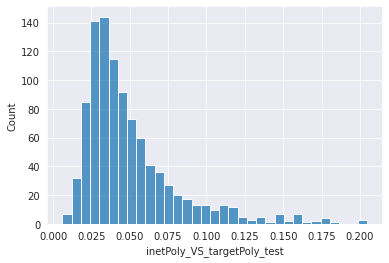

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

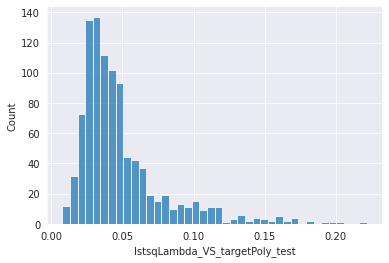

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

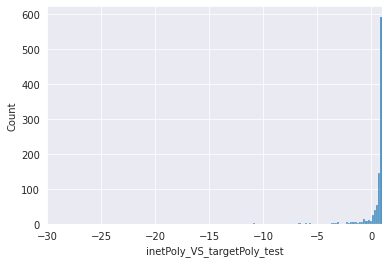

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

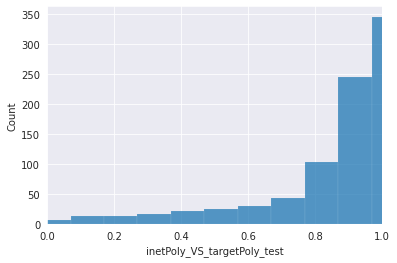

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

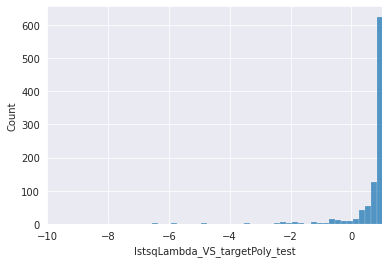

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

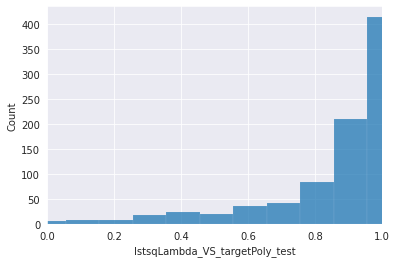

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.0055*a**1.0 - 0.5873*a**2.0 - 0.937*a**3.0 - 0.067*a**4.0 + 0.5663

LSTSQ Target Poly:


0.5107*a**1.0 - 2.8079*a**2.0 + 2.4283*a**3.0 - 3.0509*a**4.0 + 1.4362*a**5.0 + 0.5454

LSTSQ Lambda Poly:


0.5107*a**1.0 - 2.8079*a**2.0 + 2.4283*a**3.0 - 3.0509*a**4.0 + 1.4362*a**5.0 + 0.5454

I-Net Poly:


-0.00469999993219972*a**1.0 - 0.809499979019165*a**2.0 - 0.790000021457672*a**3.0 - 0.43639999628067*a**4.0 + 0.511600017547607*a**5.0 + 0.586700022220612

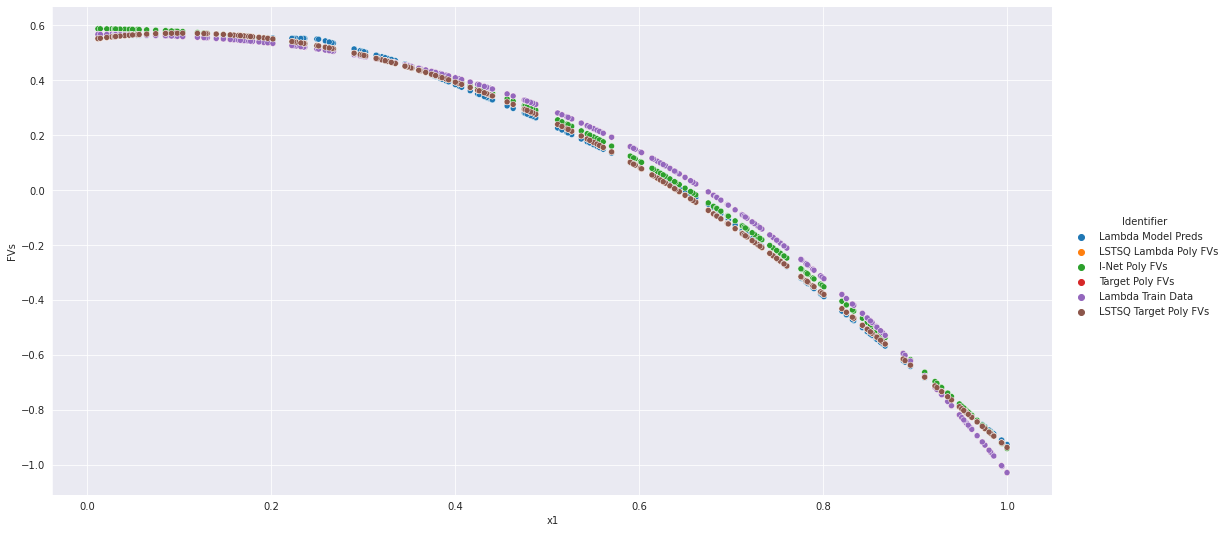

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008470286990706665 | 0.999563058009598  |   -    |  0.5107*a**1.0 - 2.8079*a**2.0 + 2.4283*a**3.0 -   |
|            vs.            |                      |                    |        |       3.0509*a**4.0 + 1.4362*a**5.0 + 0.5454       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0184662880546672

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

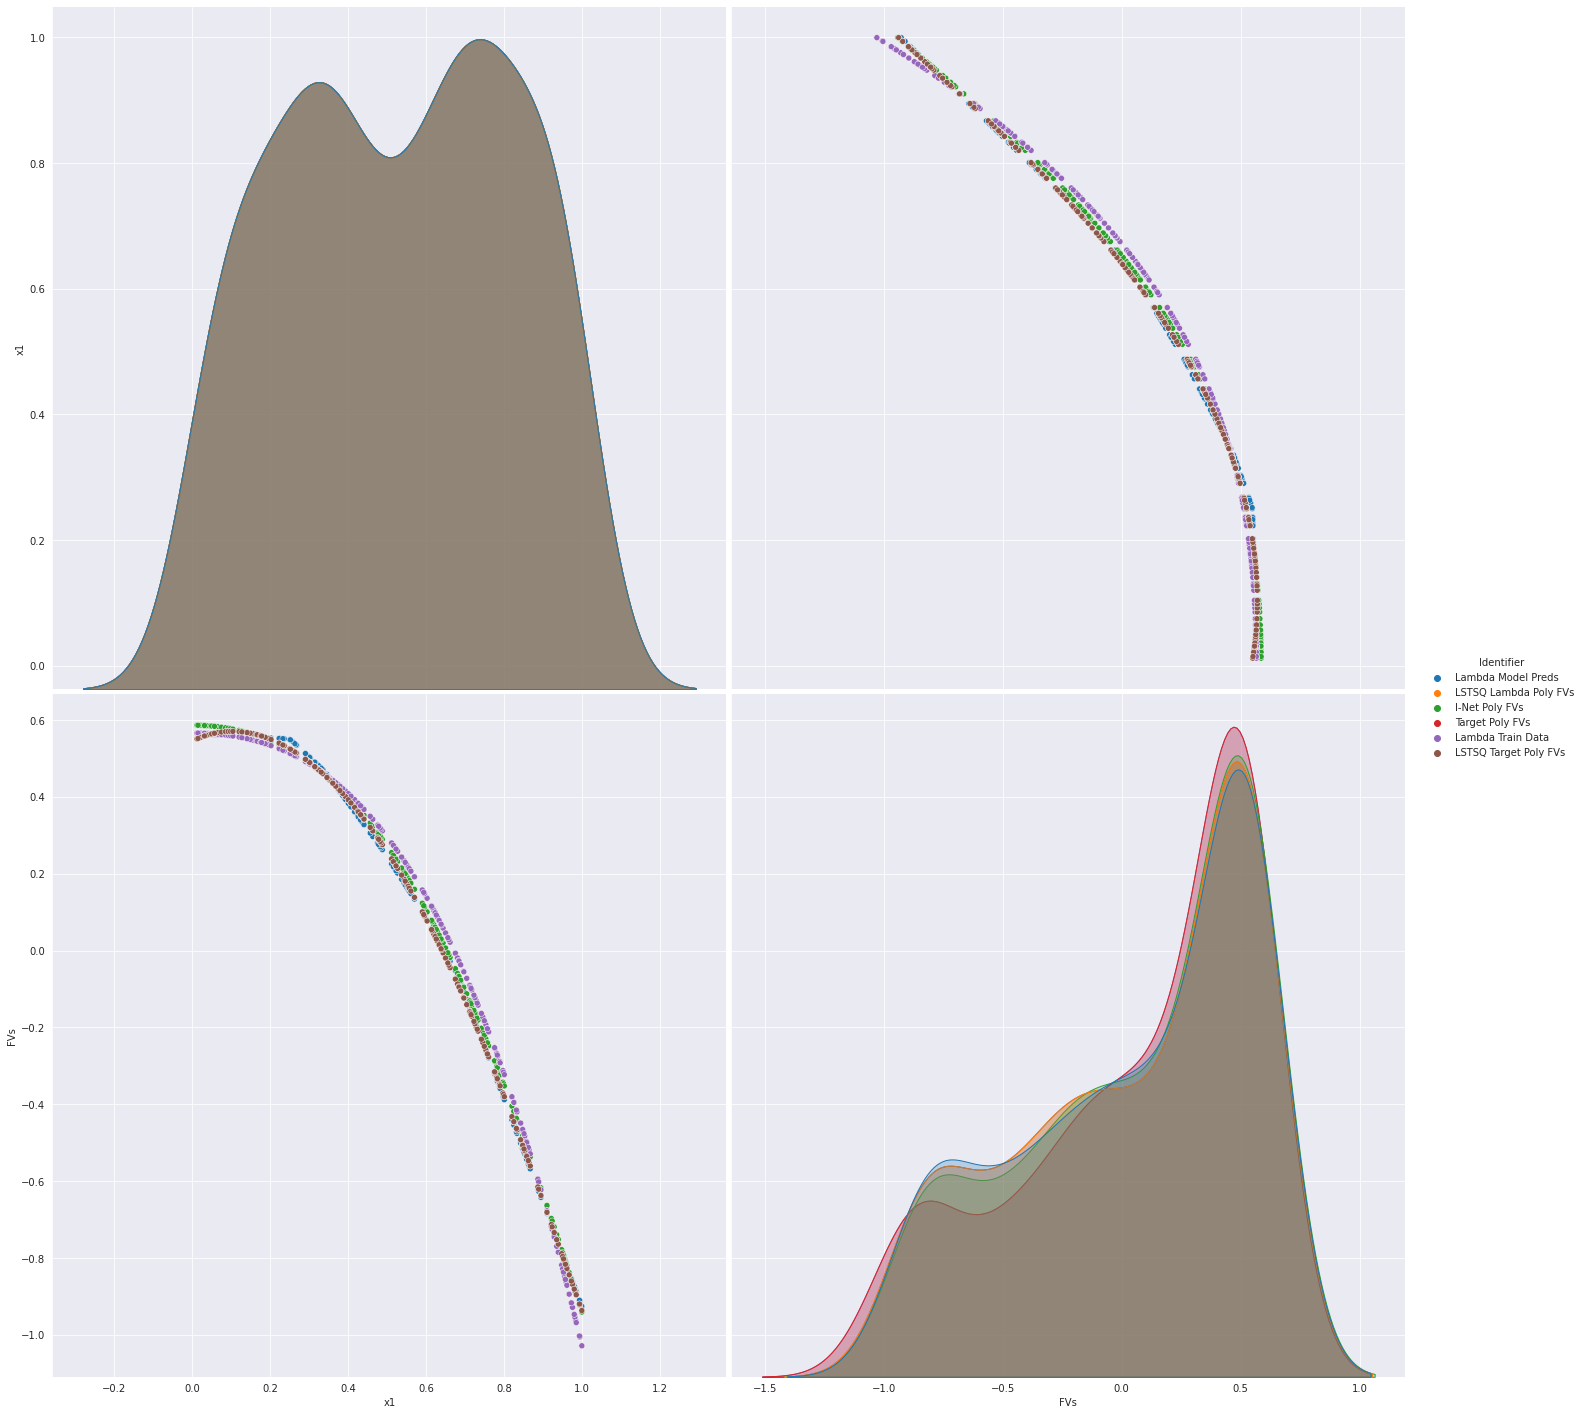

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008470286990706665 | 0.999563058009598  |   -    |  0.5107*a**1.0 - 2.8079*a**2.0 + 2.4283*a**3.0 -   |
|            vs.            |                      |                    |        |       3.0509*a**4.0 + 1.4362*a**5.0 + 0.5454       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0184662880546672

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

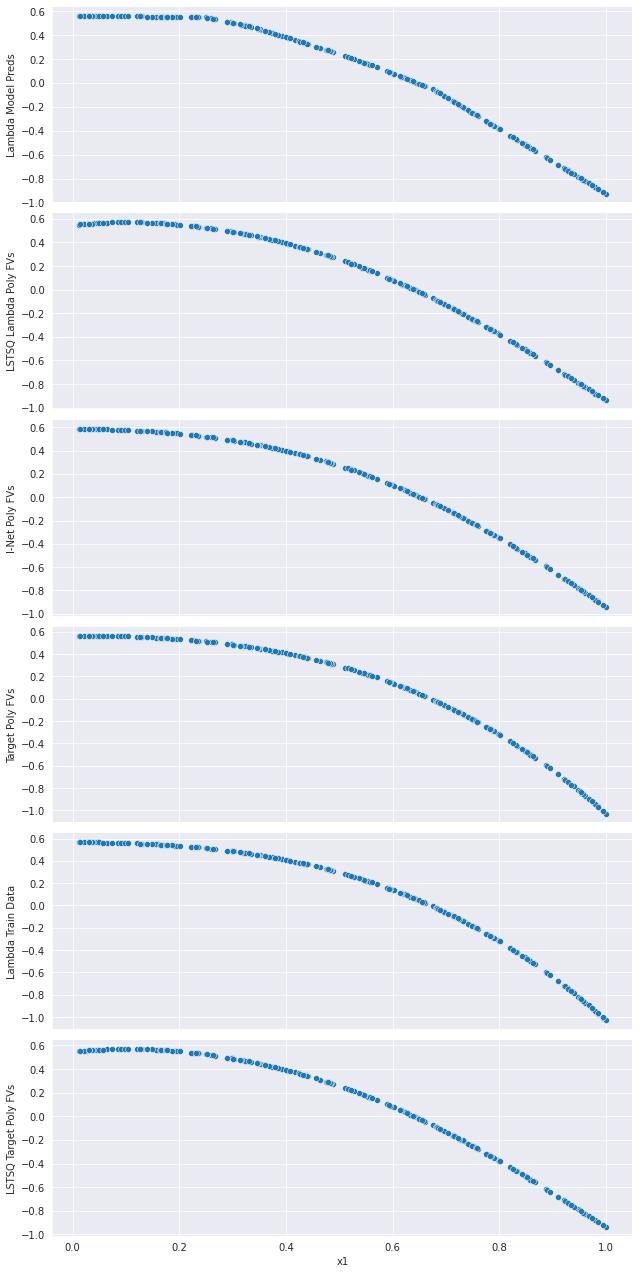

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008470286990706665 | 0.999563058009598  |   -    |  0.5107*a**1.0 - 2.8079*a**2.0 + 2.4283*a**3.0 -   |
|            vs.            |                      |                    |        |       3.0509*a**4.0 + 1.4362*a**5.0 + 0.5454       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0184662880546672

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0436


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3554


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.5499


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()